In [3]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import seaborn as sns
import re
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'notebook'

In [5]:
from scipy import stats
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import scipy.stats as stats
import seaborn as sns

In [11]:
old_incidents=pd.read_csv("LFB Incident data from 2009 - 2017.xls", sep=',', low_memory=False)
recent_incidents=pd.read_csv("LFB Incident data from 2018 onwards.xls", sep=',', low_memory=False)

In [13]:
incidents=pd.concat([old_incidents, recent_incidents], axis=0) #Concatenate both dataframes

In [15]:
old_mob=pd.read_csv("LFB Mobilisation data from January 2009 - 2014.xls", sep=';', low_memory=False)
middle_mob=pd.read_csv("LFB Mobilisation data from 2015 - 2020.xls", sep=';', low_memory=False)
recent_mob=pd.read_csv("LFB Mobilisation data 2021 - 2024.xls", sep=';', low_memory=False)

In [17]:
mobs=pd.concat([old_mob, middle_mob, recent_mob], axis=0)

In [19]:
mobs_dupes=mobs.groupby('IncidentNumber').size()
print("Duplicates in mob:")
print(mobs_dupes)

Duplicates in mob:
IncidentNumber
1092        1
1111        1
1112        1
1121        2
1131        1
           ..
99989151    1
99992151    2
99995151    2
99998151    1
99999151    1
Length: 1652636, dtype: int64


In [21]:
mobs.infer_datetime_format=True
mobs['DateAndTimeMobilised'] = pd.to_datetime(mobs['DateAndTimeMobilised'], format='mixed', errors='coerce')
mobs['Weekday'] = mobs['DateAndTimeMobilised'].dt.strftime('%A') #get weekday
mobs["Month"] = pd.to_datetime(mobs['DateAndTimeMobilised']).dt.month
mobs["Day_Month"] = pd.to_datetime(mobs['DateAndTimeMobilised']).dt.day
mobs["Incident_Date"]=mobs["DateAndTimeMobilised"].dt.strftime('%Y.%m.%d')
mobs.head(5)

,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description,BoroughName,WardName,Weekday,Month,Day_Month,Incident_Date
0,235138081,2009,0,38426,H271,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,01.01.2009 00:23,H27,Battersea,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
1,235138081,2009,0,38427,H212,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,01.01.2009 00:12,H21,Clapham,Home Station,2,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
2,2091,2009,0,38429,A341,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,01.01.2009 00:17,A34,Edmonton,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
3,3091,2009,0,38430,G232,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210,01.01.2009 00:20,01.01.2009 00:20,G23,Hillingdon,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
4,5091,2009,0,38432,A311,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233,01.01.2009 00:11,01.01.2009 00:22,A31,Holloway,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01


In [22]:
mobs = mobs.reset_index()

In [23]:
mobs.head()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description,BoroughName,WardName,Weekday,Month,Day_Month,Incident_Date
0,0,235138081,2009,0,38426,H271,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,01.01.2009 00:23,H27,Battersea,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
1,1,235138081,2009,0,38427,H212,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,01.01.2009 00:12,H21,Clapham,Home Station,2,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
2,2,2091,2009,0,38429,A341,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,01.01.2009 00:17,A34,Edmonton,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
3,3,3091,2009,0,38430,G232,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210,01.01.2009 00:20,01.01.2009 00:20,G23,Hillingdon,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01
4,4,5091,2009,0,38432,A311,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233,01.01.2009 00:11,01.01.2009 00:22,A31,Holloway,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,NaN,NaN,Thursday,1,1,2009.01.01


In [13]:
mobs['IncidentNumber'].nunique()

1652636

In [27]:
incidents.infer_datetime_format=True
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], format='mixed', errors='coerce')
incidents['Weekday'] = incidents['DateOfCall'].dt.strftime('%A') #get weekday
incidents["Month"] = pd.to_datetime(incidents['DateOfCall']).dt.month
incidents["Day_Month"] = pd.to_datetime(incidents['DateOfCall']).dt.day
incidents["Incident_Date"]=incidents["DateOfCall"].dt.strftime('%Y.%m.%d')
incidents.head(5)

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),NumCalls,Weekday,Month,Day_Month,Incident_Date
0,235138081.00,2009-01-01,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to gazetteer location,SW11 4LB,SW11,NaN,NaN,E09000032,WANDSWORTH,Wandsworth,E05014010,Battersea Park,Battersea Park,528652.0,176830.0,528650,176850,51.475812,-0.148894,London,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2,60,255,1.0,Thursday,1,1,2009.01.01
1,1091.00,2009-01-01,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1 7SG,SE1,NaN,NaN,E09000022,LAMBETH,Lambeth,E05014118,Waterloo & South Bank,Waterloo & South Bank,530485.0,179007.0,530450,179050,51.494957,-0.121712,London,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN,1,60,255,1.0,Thursday,1,1,2009.01.01
2,2091.00,2009-01-01,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside gazetteer location,N9 9EL,N9,NaN,NaN,E09000010,ENFIELD,Enfield,E05013682,Haselbury,Haselbury,533773.0,194492.0,533750,194450,51.633342,-0.068488,London,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1,60,255,2.0,Thursday,1,1,2009.01.01
3,3091.00,2009-01-01,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,UB10,1.000215e+11,21401491.0,E09000017,HILLINGDON,Hillingdon,E05013571,Hillingdon East,Hillingdon East,507738.0,182805.0,507750,182850,51.533882,-0.448089,London,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0,1,60,255,2.0,Thursday,1,1,2009.01.01
4,5091.00,2009-01-01,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7 8HG,N7,NaN,NaN,E09000019,ISLINGTON,Islington,E05013708,Laycock,Laycock,531058.0,185307.0,531050,185350,51.551441,-0.111120,London,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2,60,255,1.0,Thursday,1,1,2009.01.01


In [29]:
incidents = incidents.reset_index()

In [31]:
mobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496800 entries, 0 to 2496799
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   index                     int64         
 1   IncidentNumber            object        
 2   CalYear                   int64         
 3   HourOfCall                int64         
 4   ResourceMobilisationId    int64         
 5   Resource_Code             object        
 6   PerformanceReporting      object        
 7   DateAndTimeMobilised      datetime64[ns]
 8   DateAndTimeMobile         object        
 9   DateAndTimeArrived        object        
 10  TurnoutTimeSeconds        float64       
 11  TravelTimeSeconds         float64       
 12  AttendanceTimeSeconds     int64         
 13  DateAndTimeLeft           object        
 14  DateAndTimeReturned       object        
 15  DeployedFromStation_Code  object        
 16  DeployedFromStation_Name  object        
 17  Deployed

In [33]:
incidents=incidents.drop(['PropertyType', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'IncGeo_WardCode', 'Postcode_full', 'Easting_m', 'Northing_m', 'FRS', 'NumCalls', 'UPRN', 'USRN', 'Latitude', 'Longitude'], axis=1) 

In [35]:
mobs=mobs.drop(['WardName', 'PlusCode_Code', 'PlusCode_Description', 'Resource_Code', 'DeployedFromStation_Code', 'DelayCodeId'], axis=1) 

In [37]:
# Ensure "IncidentNumber" column exists in both dataframes
if "IncidentNumber" not in incidents.columns or "IncidentNumber" not in mobs.columns:
    raise KeyError("Missing 'IncidentNumber' column in one of the datasets.")

# Extract unique IncidentNumbers, ensuring all are treated as strings
combined_incident_numbers = (
    pd.concat([incidents["IncidentNumber"], mobs["IncidentNumber"]])
    .dropna()  # Remove NaN values
    .map(str)  # Convert non-null values to string
    .unique()
)

# Function to classify ID formats
def classify_id(incident_number):
    if re.fullmatch(r"\d+", incident_number):  # Pure integer
        return "Integer"
    elif re.fullmatch(r"\d+\.\d+", incident_number):  # Float-like
        return "Float"
    elif re.fullmatch(r"\d+-\d+", incident_number):  # Hyphenated
        return "Hyphenated"
    elif re.fullmatch(r"\d+E\d+", incident_number, re.IGNORECASE):  # Scientific notation
        return "Scientific Notation"
    else:
        return "Other"

# Analyze variations
variations = {category: [] for category in ["Integer", "Float", "Hyphenated", "Scientific Notation", "Other"]}
for num in combined_incident_numbers:
    category = classify_id(num)
    variations[category].append(num)

# Display results
for category, examples in variations.items():
    print(f"{category} ({len(examples)} examples): {examples[:5]}")

Integer (693226 examples): ['235138081', '2091', '3091', '5091', '6091']
Float (768218 examples): ['235138081.00', '1091.00', '2091.00', '3091.00', '5091.00']
Hyphenated (1029771 examples): ['162970-23112015', '160003-17112015', '160002-17112015', '160005-17112015', '160006-17112015']
Scientific Notation (0 examples): []
Other (0 examples): []


In [39]:
# Function to clean and convert IncidentNumber to integer
def clean_incident_number(incident_number):
    incident_number = str(incident_number)  # Ensure it's a string
    if "." in incident_number:  # Convert float-like numbers
        return int(float(incident_number))
    elif "-" in incident_number:  # Remove hyphen and convert to int
        return int(incident_number.replace("-", ""))
    return int(incident_number)  # Directly convert integers

# Apply transformation to both dataframes
incidents["IncidentNumber"] = incidents["IncidentNumber"].dropna().map(clean_incident_number)
mobs["IncidentNumber"] = mobs["IncidentNumber"].dropna().map(clean_incident_number)

# Ensure the column is now int64 type
incidents["IncidentNumber"] = incidents["IncidentNumber"].astype("int64")
incidents["IncidentNumber"] = incidents["IncidentNumber"].astype("int64")

# Confirm transformation
print(incidents["IncidentNumber"].dtype)  # Should print int64
print(incidents["IncidentNumber"].dtype)  # Should print int64

int64
int64


In [41]:
incidents_dupes=incidents.groupby('IncidentNumber').size()
print("Duplicates in incidents:")
print(incidents_dupes)

Duplicates in incidents:
IncidentNumber
1091              1
1092              1
1102              1
1109              1
1111              1
                 ..
22224631122024    1
22224831122024    1
22224931122024    1
22225031122024    1
22225131122024    1
Length: 1793315, dtype: int64


In [43]:
mobs_dupes=mobs.groupby('IncidentNumber').size()
print("Duplicates in mob:")
print(mobs_dupes)

Duplicates in mob:
IncidentNumber
1092              1
1111              1
1112              1
1121              2
1131              1
                 ..
21394931122022    1
21395131122022    1
21395331122022    1
21395431122022    1
21395731122022    1
Length: 1652636, dtype: int64


In [45]:
merged_check = pd.merge(incidents[['IncidentNumber']], mobs[['IncidentNumber']], how='outer', indicator=True)

In [47]:
compatible_rows=merged_check[merged_check['_merge'] == 'both']

In [49]:
compat_mobs=mobs[mobs['IncidentNumber'].isin(compatible_rows['IncidentNumber'])]
compat_incidents=incidents[incidents['IncidentNumber'].isin(compatible_rows['IncidentNumber'])]

In [51]:
merge=pd.merge(compat_mobs, compat_incidents, on=['IncidentNumber', 'Incident_Date'], how='left', suffixes=('_compat_mobs', '_compat_incidents'))

In [53]:
merge.loc[merge["StopCodeDescription"] == "Special Service", "StopCodeDescription"] = merge["SpecialServiceType"]
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489019 entries, 0 to 2489018
Data columns (total 50 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   index_compat_mobs                       int64         
 1   IncidentNumber                          int64         
 2   CalYear_compat_mobs                     int64         
 3   HourOfCall_compat_mobs                  int64         
 4   ResourceMobilisationId                  int64         
 5   PerformanceReporting                    object        
 6   DateAndTimeMobilised                    datetime64[ns]
 7   DateAndTimeMobile                       object        
 8   DateAndTimeArrived                      object        
 9   TurnoutTimeSeconds                      float64       
 10  TravelTimeSeconds                       float64       
 11  AttendanceTimeSeconds                   int64         
 12  DateAndTimeLeft                         ob

In [55]:
merge.drop('SpecialServiceType', axis=1)

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,BoroughName,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents
0,0,235138081,2009,0,38426,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,01.01.2009 00:23,Battersea,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,01.01.2009 00:12,Clapham,Home Station,2,NaN,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,01.01.2009 00:17,Edmonton,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0
3,3,3091,2009,0,38430,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210,01.01.2009 00:20,01.01.2009 00:20,Hillingdon,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,3.0,2009-01-01,2009.0,00:04:27,0.0,Fire,Secondary Fire,Outdoor,On land associated with building,UB10,Hillingdon,507750.0,182850.0,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0
4,4,5091,2009,0,38432,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233,01.01.2009 00:11,01.01.2009 00:22,Holloway,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,4.0,2009-01-01,2009.0,00:05:39,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N7,Islington,531050.0,185350.0,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489014,711366,20324029112024,2024,23,6837328,2,2024-11-29 23:28:00,29.11.2024 23:30,29.11.2024 23:36,110.0,379.0,489,29.11.2024 23:40,NaN,Southall,Home Station,2,Not held up,EALING,Friday,11,29,2024.11.29,793894.0,2024-11-29,2024.0,23:28:44,23.0,False Alarm,AFA,Dwelling,Correct incident location,W7,Ealing,515750.0,181650.0,Ealing,401.0,Ealing,489.0,Southall,2.0,2.0,2.0,60.0,430.0,Friday,11.0,29.0
2489015,711367,20324129112024,2024,23,6837329,1,2024-11-29 23:29:00,29.11.2024 23:30,29.11.2024 23:34,69.0,246.0,315,29.11.2024 23:56,NaN,West Norwood,Home Station,1,NaN,LAMBETH,Friday,11,29,2024.11.29,793895.0,2024-11-29,2024.0,23:29:25,23.0,Special Service,Assist other agencies,Dwelling,Within same building,SE27,Lambeth,531350.0,172050.0,West Norwood,315.0,West Norwood,NaN,NaN,1.0,1.0,1.0,60.0,430.0,Friday,11.0,29.0
2489

In [57]:
merge.infer_datetime_format=True
merge['DateAndTimeMobilised'] = pd.to_datetime(merge['DateAndTimeMobilised'],errors='coerce')
merge["Day"] = pd.to_datetime(merge['DateAndTimeMobilised']).dt.day
merge.head(5)

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,BoroughName,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents,Day
0,0,235138081,2009,0,38426,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,01.01.2009 00:23,Battersea,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,01.01.2009 00:12,Clapham,Home Station,2,NaN,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,01.01.2009 00:17,Edmonton,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,NaN,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1
3,3,3091,2009,0,38430,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210,01.01.2009 00:20,01.01.2009 00:20,Hillingdon,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,3.0,2009-01-01,2009.0,00:04:27,0.0,Fire,Secondary Fire,NaN,Outdoor,On land associated with building,UB10,Hillingdon,507750.0,182850.0,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1
4,4,5091,2009,0,38432,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233,01.01.2009 00:11,01.01.2009 00:22,Holloway,Home Station,1,NaN,NaN,Thursday,1,1,2009.01.01,4.0,2009-01-01,2009.0,00:05:39,0.0,Fire,Secondary Fire,NaN,Outdoor,In street outside gazetteer location,N7,Islington,531050.0,185350.0,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1


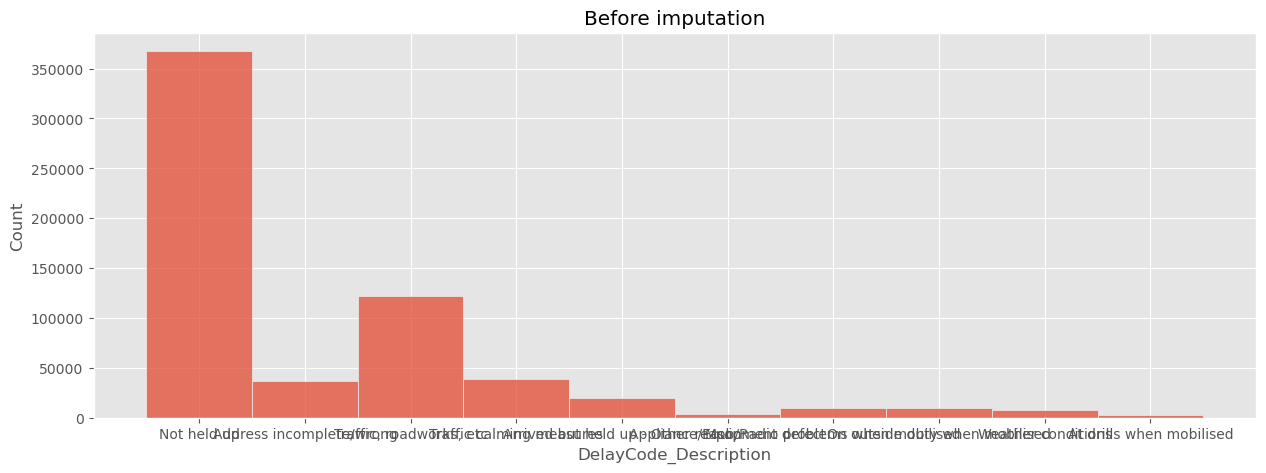

In [61]:
plt.figure(figsize=(15,5))
sns.histplot(merge.DelayCode_Description)
plt. title("Before imputation")
plt.show(sns)

In [67]:
roadworks=mobs[mobs['DelayCode_Description']=='Traffic, roadworks, etc']
calm=mobs[mobs['DelayCode_Description']=='Traffic calming measures']
address=mobs[mobs['DelayCode_Description']=='Address incomplete/wrong']
smooth=mobs[mobs['DelayCode_Description']=='Not held up']
radio=mobs[mobs['DelayCode_Description']=='Mob/Radio problems when mobilised']
outside_duty=mobs[mobs['DelayCode_Description']=='on outside duty when mobilised']
weather=mobs[mobs['DelayCode_Description']=='Weather conditions']
equipment=mobs[mobs['DelayCode_Description']=='Appliance/Equipment defect']
drills=mobs[mobs['DelayCode_Description']=='At drills when mobilised']

In [69]:
roadworks.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,121922.000000,1.219220e+05,121922.000000,121922.000000,1.219220e+05,121922,121548.000000,121553.000000,121922.000000,121922.000000,121922.000000,121922.000000
mean,424415.989485,6.407240e+12,2017.306565,13.782426,5.030490e+06,2017-10-26 14:42:04.821278976,79.939004,429.983637,509.998606,1.224217,6.657978,15.931423
min,33.000000,1.143000e+03,2009.000000,0.000000,3.847300e+04,2009-01-01 00:43:00,0.000000,0.000000,360.000000,1.000000,1.000000,1.000000
25%,211924.500000,1.378654e+08,2014.000000,11.000000,4.341544e+06,2014-06-11 17:38:00,53.000000,332.000000,405.000000,1.000000,4.000000,9.000000
50%,419249.000000,4.398921e+12,2017.000000,14.000000,5.007724e+06,2017-10-10 23:52:00,73.000000,399.000000,480.000000,1.000000,7.000000,16.000000
75%,627931.750000,1.239469e+13,2021.000000,17.000000,5.979311e+06,2021-11-23 19:05:15,96.000000,489.000000,565.000000,1.000000,10.000000,23.000000
max,901702.000000,2.139483e+13,2024.000000,23.000000,6.837297e+06,2024-12-11 21:15:00,1146.000000,1187.000000,1200.000000,4.000000,12.000000,31.000000
std,247675.020961,6.564806e+12,4.457584,4.997134,1.186291e+06,NaN,50.291423,144.574693,139.840753,0.419284,3.419780,8.503459


In [71]:
roadworks.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,121922.000000,1.219220e+05,121922.000000,121922.000000,1.219220e+05,121922,121548.000000,121553.000000,121922.000000,121922.000000,121922.000000,121922.000000
mean,424415.989485,6.407240e+12,2017.306565,13.782426,5.030490e+06,2017-10-26 14:42:04.821278976,79.939004,429.983637,509.998606,1.224217,6.657978,15.931423
min,33.000000,1.143000e+03,2009.000000,0.000000,3.847300e+04,2009-01-01 00:43:00,0.000000,0.000000,360.000000,1.000000,1.000000,1.000000
25%,211924.500000,1.378654e+08,2014.000000,11.000000,4.341544e+06,2014-06-11 17:38:00,53.000000,332.000000,405.000000,1.000000,4.000000,9.000000
50%,419249.000000,4.398921e+12,2017.000000,14.000000,5.007724e+06,2017-10-10 23:52:00,73.000000,399.000000,480.000000,1.000000,7.000000,16.000000
75%,627931.750000,1.239469e+13,2021.000000,17.000000,5.979311e+06,2021-11-23 19:05:15,96.000000,489.000000,565.000000,1.000000,10.000000,23.000000
max,901702.000000,2.139483e+13,2024.000000,23.000000,6.837297e+06,2024-12-11 21:15:00,1146.000000,1187.000000,1200.000000,4.000000,12.000000,31.000000
std,247675.020961,6.564806e+12,4.457584,4.997134,1.186291e+06,NaN,50.291423,144.574693,139.840753,0.419284,3.419780,8.503459


In [73]:
address.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,36932.000000,3.693200e+04,36932.000000,36932.000000,3.693200e+04,36932,36795.000000,36799.000000,36932.000000,36932.000000,36932.000000,36932.000000
mean,426223.650222,4.985388e+12,2016.144265,13.588379,4.742090e+06,2016-08-23 13:10:59.225062656,84.931512,507.406234,592.248863,1.193951,6.517140,15.718997
min,16.000000,4.152000e+03,2009.000000,0.000000,3.844600e+04,2009-01-01 00:24:00,0.000000,1.000000,360.000000,1.000000,1.000000,1.000000
25%,208685.500000,1.019191e+08,2013.000000,9.000000,4.067819e+06,2013-02-23 15:04:45,57.000000,355.000000,435.000000,1.000000,4.000000,8.000000
50%,421443.000000,1.482553e+12,2016.000000,15.000000,4.719209e+06,2016-06-17 15:06:30,77.000000,453.000000,534.000000,1.000000,7.000000,16.000000
75%,643060.000000,9.799041e+12,2020.000000,19.000000,5.549593e+06,2020-01-04 10:56:45,101.000000,615.000000,697.000000,1.000000,9.000000,23.000000
max,901741.000000,2.133353e+13,2024.000000,23.000000,6.837259e+06,2024-12-11 16:38:00,1012.000000,1192.000000,1200.000000,5.000000,12.000000,31.000000
std,255146.090623,6.012868e+12,4.318923,6.589530,1.184412e+06,NaN,50.904294,201.982338,198.359166,0.397514,3.316834,8.662131


In [75]:
smooth.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,372430.000000,3.724300e+05,372430.000000,372430.000000,3.724300e+05,372430,370313.000000,370324.000000,372430.000000,372430.000000,372430.000000,372430.000000
mean,412322.081631,5.609757e+12,2016.654276,13.110437,4.831026e+06,2017-02-28 02:18:14.831405056,88.178981,414.854708,503.256854,1.230392,6.589064,15.790310
min,2.000000,1.092000e+03,2009.000000,0.000000,3.843600e+04,2009-01-01 00:13:00,0.000000,0.000000,168.000000,1.000000,1.000000,1.000000
25%,202570.250000,1.135252e+08,2012.000000,9.000000,3.943950e+06,2012-07-18 16:33:15,58.000000,320.000000,402.000000,1.000000,4.000000,8.000000
50%,404201.000000,2.502816e+12,2017.000000,14.000000,4.888738e+06,2017-04-06 06:15:00,79.000000,383.000000,470.000000,1.000000,7.000000,16.000000
75%,612970.500000,1.109111e+13,2021.000000,18.000000,5.969412e+06,2021-11-12 22:53:30,105.000000,474.000000,556.000000,1.000000,10.000000,23.000000
max,901786.000000,2.139363e+13,2024.000000,23.000000,6.837328e+06,2024-12-11 23:52:00,1192.000000,1198.000000,1200.000000,5.000000,12.000000,31.000000
std,245319.984293,6.437538e+12,4.955772,6.191288,1.412214e+06,NaN,54.360802,143.561411,137.446514,0.423323,3.397312,8.666009


In [77]:
radio.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,9985.000000,9.985000e+03,9985.000000,9985.000000,9.985000e+03,9985,9635.000000,9635.000000,9985.000000,9985.000000,9985.000000,9985.000000
mean,378351.198097,4.759194e+12,2015.683826,12.486730,4.523097e+06,2016-03-09 18:57:33.722583808,131.165750,396.519253,528.708563,1.211417,6.569154,15.562444
min,4.000000,1.015100e+04,2009.000000,0.000000,3.861900e+04,2009-01-01 04:34:00,1.000000,0.000000,360.000000,1.000000,1.000000,1.000000
25%,141809.000000,1.019591e+08,2012.000000,7.000000,3.836932e+06,2012-01-22 05:40:00,71.000000,286.000000,402.000000,1.000000,4.000000,8.000000
50%,359780.000000,1.136127e+12,2016.000000,13.000000,4.694618e+06,2016-05-13 15:27:00,101.000000,352.000000,475.000000,1.000000,7.000000,16.000000
75%,589184.000000,8.834411e+12,2019.000000,18.000000,5.470123e+06,2019-09-30 22:05:00,153.000000,470.500000,589.000000,1.000000,9.000000,23.000000
max,901640.000000,2.139533e+13,2024.000000,23.000000,6.836832e+06,2024-12-09 19:15:00,1152.000000,1175.000000,1198.000000,4.000000,12.000000,31.000000
std,255498.462152,5.877919e+12,4.564057,6.679419,1.465844e+06,NaN,105.550325,188.319145,172.367221,0.411997,3.344480,8.679958


In [79]:
outside_duty.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
weather.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,7267.000000,7.267000e+03,7267.000000,7267.000000,7.267000e+03,7267,7232.000000,7233.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,397806.304665,4.643934e+12,2015.346773,12.096188,4.539070e+06,2015-11-22 19:31:40.423833600,94.731610,430.219549,525.023118,1.173937,7.088620,14.727948
min,114.000000,3.610100e+04,2009.000000,0.000000,3.980500e+04,2009-01-02 17:40:00,1.000000,0.000000,360.000000,1.000000,1.000000,1.000000
25%,191100.000000,1.232466e+08,2010.000000,6.000000,3.603336e+06,2010-12-20 17:37:00,62.000000,320.000000,408.000000,1.000000,3.000000,7.000000
50%,335192.000000,2.266751e+08,2015.000000,13.000000,4.492517e+06,2015-03-07 22:59:00,85.000000,389.000000,484.000000,1.000000,7.000000,15.000000
75%,562092.000000,8.493162e+12,2020.000000,18.000000,5.566044e+06,2020-02-10 20:48:00,115.000000,498.000000,587.000000,1.000000,11.000000,22.000000
max,901769.000000,2.139403e+13,2024.000000,23.000000,6.834920e+06,2024-12-10 17:55:00,955.000000,1185.000000,1200.000000,3.000000,12.000000,31.000000
std,236430.414460,6.745909e+12,4.819622,7.237067,1.362639e+06,NaN,59.334546,163.668842,156.374111,0.380169,4.013446,8.925674


In [83]:
equipment.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,3155.000000,3.155000e+03,3155.000000,3155.000000,3.155000e+03,3155,3093.000000,3094.000000,3155.000000,3155.000000,3155.000000,3155.000000
mean,402561.909033,5.075612e+12,2016.340729,12.425040,4.671865e+06,2016-11-02 02:05:19.454833664,111.218881,430.992889,543.076387,1.236767,6.481141,15.589857
min,116.000000,1.330920e+05,2009.000000,0.000000,3.860600e+04,2009-01-01 04:13:00,2.000000,1.000000,360.000000,1.000000,1.000000,1.000000
25%,155052.000000,1.048541e+08,2012.000000,7.000000,3.934986e+06,2012-06-11 22:52:00,67.000000,304.000000,407.000000,1.000000,4.000000,8.000000
50%,395151.000000,1.475604e+12,2016.000000,13.000000,4.817794e+06,2016-12-01 02:56:00,92.000000,376.000000,486.000000,1.000000,7.000000,16.000000
75%,626888.000000,9.907267e+12,2021.000000,18.000000,5.856912e+06,2021-07-04 04:35:00,131.000000,513.000000,609.000000,1.000000,9.000000,23.000000
max,901314.000000,2.137273e+13,2024.000000,23.000000,6.834037e+06,2024-12-10 19:09:00,939.000000,1178.000000,1200.000000,3.000000,12.000000,31.000000
std,260310.506351,6.183474e+12,4.998691,6.758142,1.579930e+06,NaN,81.970072,199.002017,183.250495,0.431825,3.389792,8.672570


In [85]:
drills.describe()

,index,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month,Day_Month
count,2804.000000,2.804000e+03,2804.000000,2804.000000,2.804000e+03,2804,2791.000000,2791.000000,2804.000000,2804.000000,2804.000000,2804.000000
mean,428819.645863,3.568591e+12,2015.202211,13.144080,4.438791e+06,2015-09-02 17:05:57.218259712,107.087066,389.500179,496.851641,1.164408,6.139444,15.485378
min,1480.000000,1.281220e+05,2009.000000,0.000000,4.142100e+04,2009-01-02 11:09:00,2.000000,1.000000,360.000000,1.000000,1.000000,1.000000
25%,185001.750000,7.008713e+07,2011.000000,11.000000,3.802228e+06,2011-11-08 11:50:45,63.000000,305.000000,400.000000,1.000000,3.000000,8.000000
50%,430624.500000,1.624206e+08,2014.000000,13.000000,4.390804e+06,2014-10-10 13:11:30,90.000000,361.000000,461.000000,1.000000,6.000000,15.500000
75%,659951.250000,6.292899e+12,2019.000000,15.000000,5.453380e+06,2019-08-08 19:15:00,130.000000,444.000000,548.250000,1.000000,9.000000,23.000000
max,901189.000000,2.080842e+13,2024.000000,23.000000,6.817944e+06,2024-12-04 09:50:00,816.000000,1099.000000,1192.000000,2.000000,12.000000,31.000000
std,266616.533216,5.373093e+12,4.484020,2.632964,1.392802e+06,NaN,73.573331,135.022478,130.443480,0.370711,3.316704,8.839723


In [87]:
print(merge['DelayCode_Description'].value_counts(normalize=True))

DelayCode_Description
Not held up                           0.596653
Traffic, roadworks, etc               0.196955
Traffic calming measures              0.063277
Address incomplete/wrong              0.058973
Arrived but held up - Other reason    0.031420
Mob/Radio problems when mobilised     0.016130
On outside duty when mobilised        0.015236
Weather conditions                    0.011711
Appliance/Equipment defect            0.005109
At drills when mobilised              0.004535
Name: proportion, dtype: float64


In [89]:
#normalised freq of delay categories
delay_probs = {
    'not held up': 0.596653, 
    'Traffic, roadworks, etc': 0.196955, 
    'Traffic calming measures': 0.063277, 
    'Address_incomplete/wrong': 0.058973, 
    'Mob/Radio problems when mobilised': 0.016130, 
    'Weather conditions': 0.011711, 
    'Appliance/Equipment defect': 0.005109, 
    'At drills when mobilised': 0.004535
}
#define conditional ranges for imputing 'delay'
conditions = [
    (merge['TravelTimeSeconds']>=414.854708 - 2*143.561411) & (merge['TravelTimeSeconds']<= 414.854708 + 2*143.561411), 
    (merge['TravelTimeSeconds']>=429.983637 - 2*144.574693) & (merge['TravelTimeSeconds']<=429.983637 + 2*144.574693),
    (merge['TravelTimeSeconds']>=410.400123 - 2*137.4) & (merge['TravelTimeSeconds']<=410.400123 + 2*137.4),
    (merge['AttendanceTimeSeconds']>=592.248863 - 2*198.36) & (merge['AttendanceTimeSeconds']<=592.248863 + 2*198.36),
    (merge['TurnoutTimeSeconds']>=131.165750 - 2*105.6) & (merge['TurnoutTimeSeconds']<=131.165750 + 2*105.6),
    (merge['AttendanceTimeSeconds']>=525.023118 - 2*156.37) & (merge['AttendanceTimeSeconds']<=525.023118 + 2*156.37),
    (merge['TurnoutTimeSeconds']>=111.218881 - 2*81.97) &  (merge['TurnoutTimeSeconds']<=111.218881 + 2*81.97),
    (merge['TurnoutTimeSeconds']>=107.087066 - 2*73.57) & (merge['TurnoutTimeSeconds']<=107.087066 + 2*73.57)
]

choices = ['not held up', 'Traffic, roadworks, etc', 'Traffic calming measures', 'Address_incomplete/wrong', 'Mob/Radio problems when mobilised', 'Weather conditions', 'Appliance/Equipment defect', 'At drills when mobilised']
probabilities = np.array([delay_probs[choice] for choice in choices])
probabilities /= probabilities.sum()

#conditional imputing
def conditional_impute(row):
    try:
        if pd.isna(row['DelayCode_Description']):
            condition_met = False
        #get the range index for the current travel_time ranges and probabilities
            for idx, condition in enumerate(conditions):
                if condition[row.name]: #check if condition met
                #randomly assign a delay value based on predefined probabilities.
                    row['DelayCode_Description'] = np.random.choice(choices, p=probabilities)
                    condition_met=True
                    break
                if not condition_met:
                    row['DelayCode_Description'] = np.nan                
        return row['DelayCode_Description']
    except Exception as e:
        print(f"Error processing row with travel_time {row['TravelTimeSeconds']}: {e}")
    
#Apply function to dataframe
merge['DelayCode_Description'] = merge.apply(conditional_impute, axis = 1)

print(merge.head())

   index_compat_mobs  IncidentNumber  CalYear_compat_mobs  \
0                  0       235138081                 2009   
1                  1       235138081                 2009   
2                  2            2091                 2009   
3                  3            3091                 2009   
4                  4            5091                 2009   

   HourOfCall_compat_mobs  ResourceMobilisationId PerformanceReporting  \
0                       0                   38426                    1   
1                       0                   38427                    2   
2                       0                   38429                    1   
3                       0                   38430                    1   
4                       0                   38432                    1   

  DateAndTimeMobilised DateAndTimeMobile DateAndTimeArrived  \
0  2009-01-01 00:02:00               NaN   01.01.2009 00:07   
1  2009-01-01 00:02:00  01.01.2009 00:06   01.01.2009 00:08   

In [91]:
merge.head(3)

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,BoroughName,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents,Day
0,0,235138081,2009,0,38426,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,01.01.2009 00:23,Battersea,Home Station,1,not held up,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,01.01.2009 00:12,Clapham,Home Station,2,not held up,NaN,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,01.01.2009 00:17,Edmonton,Home Station,1,not held up,NaN,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,NaN,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1


In [93]:
merge.isna().sum()

index_compat_mobs                               0
IncidentNumber                                  0
CalYear_compat_mobs                             0
HourOfCall_compat_mobs                          0
ResourceMobilisationId                          0
PerformanceReporting                            0
DateAndTimeMobilised                            0
DateAndTimeMobile                           28364
DateAndTimeArrived                              0
TurnoutTimeSeconds                          28500
TravelTimeSeconds                           28596
AttendanceTimeSeconds                           0
DateAndTimeLeft                             46381
DateAndTimeReturned                       1518098
DeployedFromStation_Name                       23
DeployedFromLocation                         1189
PumpOrder                                       0
DelayCode_Description                       14638
BoroughName                               1780363
Weekday_compat_mobs                             0


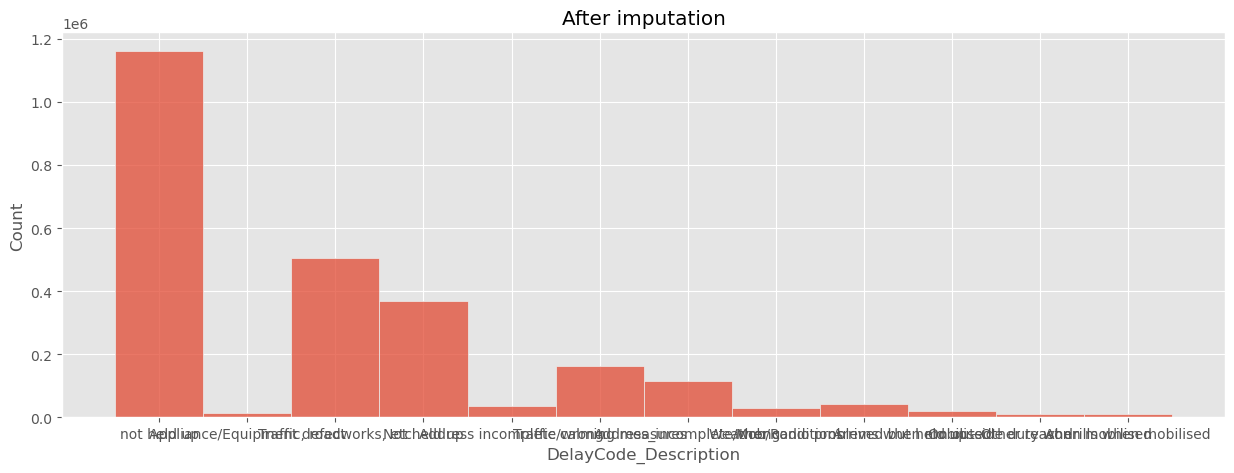

In [95]:
plt.figure(figsize=(15,5))
sns.histplot(merge.DelayCode_Description)
plt.title("After imputation")
plt.show(sns)

In [97]:
print(merge['StopCodeDescription'].value_counts())

StopCodeDescription
AFA                                690101
False alarm - Good intent          197239
Primary Fire                       193428
Secondary Fire                     110950
Effecting entry/exit                74954
Flooding                            66226
RTC                                 58678
No action (not false alarm)         28193
False alarm - Malicious             23797
Lift Release                        22854
Assist other agencies               15608
Making Safe (not RTC)               12063
Spills and Leaks (not RTC)          10526
Hazardous Materials incident         9178
Advice Only                          6806
Animal assistance incidents          6770
Medical Incident                     6438
Other rescue/release of persons      5302
Removal of objects from people       4529
Other Transport incident             3954
Evacuation (no fire)                 3457
Suicide/attempts                     3215
Stand By                             1550
Medical Incide

In [99]:
merge=merge.drop(['SpecialServiceType', 'BoroughName', 'DateAndTimeReturned'], axis=1)

In [101]:
columns_to_fill=['FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'SecondPumpArriving_DeployedFromStation']
merge[columns_to_fill]=merge[columns_to_fill].fillna(-1)

In [103]:
merge.head(3)

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents,Day
0,0,235138081,2009,0,38426,1,2009-01-01 00:02:00,NaN,01.01.2009 00:07,NaN,NaN,319,01.01.2009 00:16,Battersea,Home Station,1,not held up,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342,01.01.2009 00:12,Clapham,Home Station,2,not held up,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308,01.01.2009 00:16,Edmonton,Home Station,1,not held up,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,-1.0,-1,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1


In [105]:
print(merge.isna().sum())

index_compat_mobs                              0
IncidentNumber                                 0
CalYear_compat_mobs                            0
HourOfCall_compat_mobs                         0
ResourceMobilisationId                         0
PerformanceReporting                           0
DateAndTimeMobilised                           0
DateAndTimeMobile                          28364
DateAndTimeArrived                             0
TurnoutTimeSeconds                         28500
TravelTimeSeconds                          28596
AttendanceTimeSeconds                          0
DateAndTimeLeft                            46381
DeployedFromStation_Name                      23
DeployedFromLocation                        1189
PumpOrder                                      0
DelayCode_Description                      14638
Weekday_compat_mobs                            0
Month_compat_mobs                              0
Day_Month_compat_mobs                          0
Incident_Date       

In [107]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489019 entries, 0 to 2489018
Data columns (total 48 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   index_compat_mobs                       int64         
 1   IncidentNumber                          int64         
 2   CalYear_compat_mobs                     int64         
 3   HourOfCall_compat_mobs                  int64         
 4   ResourceMobilisationId                  int64         
 5   PerformanceReporting                    object        
 6   DateAndTimeMobilised                    datetime64[ns]
 7   DateAndTimeMobile                       object        
 8   DateAndTimeArrived                      object        
 9   TurnoutTimeSeconds                      float64       
 10  TravelTimeSeconds                       float64       
 11  AttendanceTimeSeconds                   int64         
 12  DateAndTimeLeft                         ob

In [109]:
merge.shape

(2489019, 48)

In [111]:
dmerge=merge.copy()

In [113]:
clean_merge=merge.dropna()

In [115]:
clean_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1514797 entries, 1 to 2489018
Data columns (total 48 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   index_compat_mobs                       1514797 non-null  int64         
 1   IncidentNumber                          1514797 non-null  int64         
 2   CalYear_compat_mobs                     1514797 non-null  int64         
 3   HourOfCall_compat_mobs                  1514797 non-null  int64         
 4   ResourceMobilisationId                  1514797 non-null  int64         
 5   PerformanceReporting                    1514797 non-null  object        
 6   DateAndTimeMobilised                    1514797 non-null  datetime64[ns]
 7   DateAndTimeMobile                       1514797 non-null  object        
 8   DateAndTimeArrived                      1514797 non-null  object        
 9   TurnoutTimeSeconds           

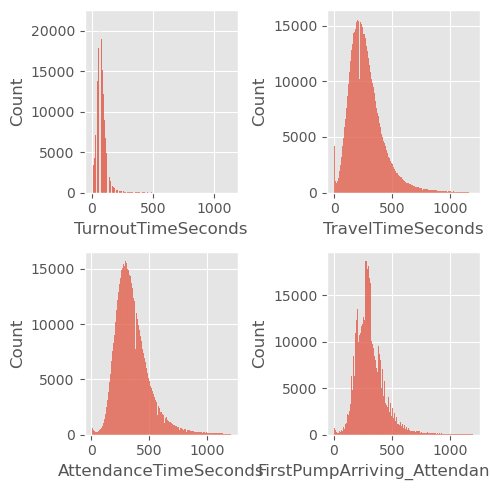

In [117]:
sns.color_palette("crest", as_cmap=True)
fig, axs = plt.subplots(2,2, figsize=(5,5))
sns.histplot(clean_merge.TurnoutTimeSeconds, ax=axs[0,0])
sns.histplot(clean_merge.TravelTimeSeconds, ax=axs[0,1])
sns.histplot(clean_merge.AttendanceTimeSeconds, ax=axs[1,0])
sns.histplot(clean_merge.FirstPumpArriving_AttendanceTime, ax=axs[1,1])
plt.tight_layout()
plt.show()

In [119]:
clean_merge_tot_zero=clean_merge[clean_merge['TurnoutTimeSeconds']==0]
clean_merge_tot_zero.head()
clean_merge_tot_zero.describe()
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(0, clean_merge['TurnoutTimeSeconds'].mean())

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\3837851636.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
clean_merge_tot_10=clean_merge[clean_merge['TurnoutTimeSeconds']<=10]
clean_merge_tot_10.describe()

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month_compat_mobs,Day_Month_compat_mobs,index_compat_incidents,DateOfCall,CalYear_compat_incidents,HourOfCall_compat_incidents,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Month_compat_incidents,Day_Month_compat_incidents,Day
count,26266.000000,2.626600e+04,26266.000000,26266.000000,2.626600e+04,26266,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.00000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000,26266.000000
mean,438273.590916,3.752024e+12,2015.131691,14.153621,4.622149e+06,2015-08-31 13:37:46.508794880,6.214117,264.963146,271.177263,1.182632,6.734904,20.978185,438525.282038,2015-08-30 23:35:49.364197120,2015.131691,14.153621,530225.519683,180659.076372,265.512450,83.017818,1.24823,1.419706,1.480736,78.807432,411.497297,6.734904,20.978185,20.978185
min,113.000000,4.123000e+03,2009.000000,0.000000,4.763200e+04,2009-01-13 23:16:00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,221.000000,2009-01-13 00:00:00,2009.000000,0.000000,504050.000000,157250.000000,1.000000,-1.000000,1.00000,1.000000,1.000000,60.000000,255.000000,1.000000,1.000000,1.000000
25%,238118.250000,8.021615e+07,2011.000000,12.000000,3.695600e+06,2011-05-24 16:12:15,4.000000,126.000000,132.000000,1.000000,4.000000,16.000000,247639.500000,2011-05-24 00:00:00,2011.000000,12.000000,525250.000000,176750.000000,135.000000,-1.000000,1.00000,1.000000,1.000000,60.000000,260.000000,4.000000,16.000000,16.000000
50%,429996.000000,1.545721e+08,2013.000000,14.000000,4.213830e+06,2013-11-18 04:46:00,6.000000,242.000000,248.000000,1.000000,7.000000,21.000000,443670.000000,2013-11-17 12:00:00,2013.000000,14.000000,530250.000000,181250.000000,244.000000,-1.000000,1.00000,1.000000,1.000000,60.000000,290.000000,7.000000,21.000000,21.000000
75%,635398.750000,6.517901e+12,2020.000000,17.000000,5.744420e+06,2020-11-14 14:16:30,8.000000,369.000000,376.000000,1.000000,9.000000,26.000000,614615.500000,2020-11-14 00:00:00,2020.000000,17.000000,535350.000000,185050.000000,362.000000,-1.000000,1.00000,2.000000,2.000000,60.000000,352.000000,9.000000,26.000000,26.000000
max,901744.000000,2.139183e+13,2024.000000,23.000000,6.837266e+06,2024-11-29 21:20:00,10.000000,1195.000000,1200.000000,9.000000,12.000000,31.000000,988240.000000,2024-11-29 00:00:00,2024.000000,23.000000,559250.000000,200650.000000,1200.000000,1198.000000,13.00000,15.000000,129.000000,35197.000000,170119.000000,12.000000,31.000000,31.000000
std,239209.621417,6.075372e+12,5.032896,4.244144,1.136450e+06,NaN,2.572118,196.585772,197.016685,0.515546,3.228155,6.104167,225192.870345,NaN,5.032896,4.244144,9420.580569,7125.207265,188.675198,175.588022,0.63706,0.845209,1.463832,296.975856,1691.235344,3.228155,6.104167,6.104167


In [123]:
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(1, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(2, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(3, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(4, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(5, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(6, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(7, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(8, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(9, clean_merge['TurnoutTimeSeconds'].mean())
clean_merge['TurnoutTimeSeconds']=clean_merge['TurnoutTimeSeconds'].replace(10, clean_merge['TurnoutTimeSeconds'].mean())

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2889984459.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2889984459.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2889984459.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [125]:
clean_merge_travel_15=clean_merge[clean_merge['TravelTimeSeconds']<=15]
clean_merge_travel_15.head()
clean_merge_travel_15.describe()

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month_compat_mobs,Day_Month_compat_mobs,index_compat_incidents,DateOfCall,CalYear_compat_incidents,HourOfCall_compat_incidents,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Month_compat_incidents,Day_Month_compat_incidents,Day
count,13725.000000,1.372500e+04,13725.000000,13725.000000,1.372500e+04,13725,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000,13725.000000
mean,414051.232641,7.199963e+12,2018.075920,13.674973,5.205009e+06,2018-08-05 16:23:48.559563008,161.154366,4.828124,150.195118,1.203862,6.564299,20.872423,466460.656321,2018-08-05 02:48:42.491803392,2018.075920,13.674973,531121.351548,180066.036430,145.962477,118.772095,1.385865,1.670383,1.760073,81.507104,454.983898,6.564299,20.872423,20.872423
min,40.000000,3.101000e+03,2009.000000,0.000000,3.848000e+04,2009-01-01 00:52:00,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2009-01-01 00:00:00,2009.000000,0.000000,504650.000000,157050.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,60.000000,255.000000,1.000000,1.000000,1.000000
25%,210047.000000,2.251401e+08,2015.000000,10.000000,4.578937e+06,2015-10-15 09:18:00,75.000000,2.000000,18.000000,1.000000,4.000000,16.000000,238793.000000,2015-10-15 00:00:00,2015.000000,10.000000,525650.000000,175750.000000,21.000000,-1.000000,1.000000,1.000000,1.000000,60.000000,326.000000,4.000000,16.000000,16.000000
50%,404459.000000,6.203722e+12,2019.000000,14.000000,5.450379e+06,2019-08-17 05:06:00,92.000000,4.000000,100.000000,1.000000,7.000000,21.000000,454191.000000,2019-08-17 00:00:00,2019.000000,14.000000,531250.000000,180850.000000,110.000000,-1.000000,1.000000,1.000000,1.000000,60.000000,346.000000,7.000000,21.000000,21.000000
75%,599955.000000,1.279892e+13,2022.000000,18.000000,6.152131e+06,2022-07-30 21:24:00,242.000000,7.000000,248.000000,1.000000,9.000000,26.000000,688395.000000,2022-07-30 00:00:00,2022.000000,18.000000,536850.000000,184950.000000,239.000000,250.000000,2.000000,2.000000,2.000000,60.000000,388.000000,9.000000,26.000000,26.000000
max,901359.000000,2.139513e+13,2024.000000,23.000000,6.837191e+06,2024-11-29 19:39:00,1132.000000,15.000000,1135.000000,8.000000,12.000000,31.000000,988240.000000,2024-11-29 00:00:00,2024.000000,23.000000,557950.000000,200150.000000,1186.000000,1185.000000,9.000000,10.000000,128.000000,32206.000000,149826.000000,12.000000,31.000000,31.000000
std,236463.630299,6.417700e+12,4.657795,5.764790,1.229774e+06,NaN,141.635591,3.981061,154.117372,0.505406,3.375427,6.301087,267704.103105,NaN,4.657795,5.764790,9450.597187,7288.987575,138.534958,182.285134,0.775727,0.983721,1.803542,380.379682,2087.450293,3.375427,6.301087,6.301087


In [127]:
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(0, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(1, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(2, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(3, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(4, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(5, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(6, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(7, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(8, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(9, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(10, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(11, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(12, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(13, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(14, clean_merge['TravelTimeSeconds'].mean())
clean_merge['TravelTimeSeconds']=clean_merge['TravelTimeSeconds'].replace(15, clean_merge['TravelTimeSeconds'].mean())

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\3704548729.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\3704548729.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\3704548729.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [129]:
clean_merge_attendance_25=clean_merge[clean_merge['AttendanceTimeSeconds']<=25]
clean_merge_attendance_25.head()
clean_merge_attendance_25.describe()

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month_compat_mobs,Day_Month_compat_mobs,index_compat_incidents,DateOfCall,CalYear_compat_incidents,HourOfCall_compat_incidents,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Month_compat_incidents,Day_Month_compat_incidents,Day
count,4231.000000,4.231000e+03,4231.000000,4231.000000,4.231000e+03,4231,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.00000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000
mean,432648.535098,8.791497e+12,2019.691799,14.273694,5.613045e+06,2020-03-18 05:13:00.212716032,60.808907,268.919517,10.545498,1.118175,6.575750,20.838572,505725.180572,2020-03-17 15:01:34.445757696,2019.691799,14.273694,531573.776885,179899.255495,29.530135,21.85559,1.116048,1.307729,1.377925,74.346963,440.924604,6.575750,20.838572,20.838572
min,113.000000,1.501510e+05,2009.000000,0.000000,6.911500e+04,2009-02-17 10:11:00,11.000000,16.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2009-02-17 00:00:00,2009.000000,0.000000,505050.000000,157050.000000,1.000000,-1.00000,1.000000,1.000000,1.000000,60.000000,255.000000,1.000000,1.000000,1.000000
25%,237815.500000,3.568123e+12,2017.000000,11.000000,5.014903e+06,2017-10-28 18:37:30,20.000000,275.707872,4.000000,1.000000,4.000000,16.000000,283768.000000,2017-10-28 00:00:00,2017.000000,11.000000,525800.000000,175550.000000,5.000000,-1.00000,1.000000,1.000000,1.000000,60.000000,328.000000,4.000000,16.000000,16.000000
50%,434739.000000,8.445428e+12,2020.000000,15.000000,5.718834e+06,2020-09-30 19:56:00,78.441719,275.707872,9.000000,1.000000,7.000000,21.000000,519667.000000,2020-09-30 00:00:00,2020.000000,15.000000,531750.000000,180750.000000,11.000000,-1.00000,1.000000,1.000000,1.000000,60.000000,352.000000,7.000000,21.000000,21.000000
75%,616037.500000,1.406907e+13,2023.000000,18.000000,6.292184e+06,2023-01-28 22:55:00,78.780288,276.509649,16.000000,1.000000,9.000000,26.000000,729049.000000,2023-01-28 12:00:00,2023.000000,18.000000,537550.000000,185150.000000,19.000000,-1.00000,1.000000,1.000000,1.000000,60.000000,388.000000,9.000000,26.000000,26.000000
max,899174.000000,2.139513e+13,2024.000000,23.000000,6.837164e+06,2024-11-29 19:08:00,79.522843,278.025664,25.000000,6.000000,12.000000,31.000000,988240.000000,2024-11-29 00:00:00,2024.000000,23.000000,557950.000000,200150.000000,1186.000000,1185.00000,6.000000,8.000000,71.000000,20906.000000,149826.000000,12.000000,31.000000,31.000000
std,230190.682429,5.969866e+12,3.411291,5.219011,8.177260e+05,NaN,28.677024,42.733173,6.758813,0.379409,3.313254,6.195910,269484.467771,NaN,3.411291,5.219011,9699.700564,7607.096586,69.866059,98.30526,0.461271,0.716792,1.352757,328.903541,2338.523382,3.313254,6.195910,6.195910


In [131]:
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(0, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(1, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(2, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(3, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(4, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(5, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(6, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(7, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(8, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(9, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(10, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(11, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(12, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(13, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(14, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(15, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(16, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(17, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(18, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(19, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(20, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(21, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(22, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(23, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(24, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge['AttendanceTimeSeconds']=clean_merge['AttendanceTimeSeconds'].replace(25, clean_merge['AttendanceTimeSeconds'].mean())
clean_merge.describe()

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2278369284.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2278369284.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2278369284.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,Month_compat_mobs,Day_Month_compat_mobs,index_compat_incidents,DateOfCall,CalYear_compat_incidents,HourOfCall_compat_incidents,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Month_compat_incidents,Day_Month_compat_incidents,Day
count,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1514797,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1514797,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06,1.514797e+06
mean,4.288913e+05,5.916024e+12,2.016892e+03,1.374257e+01,4.929851e+06,2017-05-31 13:35:54.014881280,7.966980e+01,2.780748e+02,3.549788e+02,1.465943e+00,6.600489e+00,2.095001e+01,4.611739e+05,2017-05-30 23:57:33.071798016,2.016892e+03,1.374257e+01,5.305458e+05,1.804725e+05,3.123672e+02,2.348789e+02,1.694930e+00,2.002439e+00,2.074580e+00,8.773905e+01,4.749911e+02,6.600489e+00,2.095001e+01,2.095001e+01
min,0.000000e+00,1.111000e+03,2.009000e+03,0.000000e+00,3.842700e+04,2009-01-01 00:02:00,1.100000e+01,1.600000e+01,2.600000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2009-01-01 00:00:00,2.009000e+03,0.000000e+00,5.035500e+05,1.559500e+05,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.206270e+05,1.252331e+08,2.013000e+03,1.000000e+01,4.074447e+06,2013-03-18 04:18:00,5.500000e+01,1.770000e+02,2.540000e+02,1.000000e+00,4.000000e+00,1.600000e+01,2.369310e+05,2013-03-18 00:00:00,2.013000e+03,1.000000e+01,5.252500e+05,1.761500e+05,2.300000e+02,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,2.900000e+02,4.000000e+00,1.600000e+01,1.600000e+01
50%,4.251060e+05,3.396328e+12,2.017000e+03,1.400000e+01,4.985676e+06,2017-09-13 00:53:00,7.400000e+01,2.520000e+02,3.280000e+02,1.000000e+00,7.000000e+00,2.100000e+01,4.562580e+05,2017-09-13 00:00:00,2.017000e+03,1.400000e+01,5.308500e+05,1.810500e+05,2.920000e+02,2.660000e+02,1.000000e+00,2.000000e+00,2.000000e+00,6.000000e+01,3.330000e+02,7.000000e+00,2.100000e+01,2.100000e+01
75%,6.323320e+05,1.147392e+13,2.021000e+03,1.900000e+01,5.922018e+06,2021-09-09 18:48:00,9.500000e+01,3.450000e+02,4.230000e+02,2.000000e+00,1.000000e+01,2.600000e+01,6.775640e+05,2021-09-09 00:00:00,2.021000e+03,1.900000e+01,5.361500e+05,1.851500e+05,3.690000e+02,3.930000e+02,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+01,3.880000e+02,1.000000e+01,2.600000e+01,2.600000e+01
max,9.017870e+05,2.139573e+13,2.024000e+03,2.300000e+01,6.837332e+06,2024-11-29 23:44:00,1.132000e+03,1.195000e+03,1.200000e+03,1.100000e+01,1.200000e+01,3.100000e+01,9.882780e+05,2024-11-29 00:00:00,2.024000e+03,2.300000e+01,5.611500e+05,2.009500e+05,1.200000e+03,1.200000e+03,2.300000e+01,2.900000e+01,2.390000e+02,7.112800e+04,4.335980e+05,1.200000e+01,3.100000e+01,3.100000e+01
std,2.458664e+05,6.495162e+12,4.719345e+00,6.095536e+00,1.254060e+06,NaN,4.253436e+01,1.486977e+02,1.514282e+02,7.806237e-01,3.396040e+00,6.245125e+00,2.639092e+05,NaN,4.719345e+00,6.095536e+00,9.631776e+03,7.284819e+03,1.288506e+02,2.247358e+02,9.523649e-01,1.112711e+00,1.933867e+00,4.404833e+02,2.520728e+03,3.396040e+00,6.245125e+00,6.245125e+00


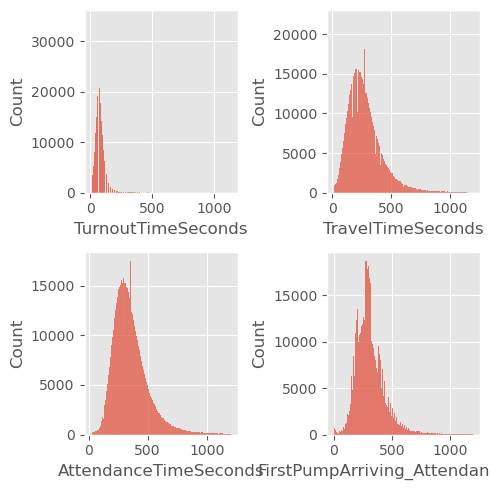

In [133]:
sns.color_palette("crest", as_cmap=True)
fig, axs = plt.subplots(2,2, figsize=(5,5))
sns.histplot(clean_merge.TurnoutTimeSeconds, ax=axs[0,0])
sns.histplot(clean_merge.TravelTimeSeconds, ax=axs[0,1])
sns.histplot(clean_merge.AttendanceTimeSeconds, ax=axs[1,0])
sns.histplot(clean_merge.FirstPumpArriving_AttendanceTime, ax=axs[1,1])
plt.tight_layout()
plt.show()

In [135]:
!pip install pyproj

In [137]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [139]:
from pyproj import Transformer
from geopy.distance import great_circle

# Define transformer for batch conversion
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)

# Convert all easting/northing in batch using NumPy
lons, lats = transformer.transform(clean_merge["Easting_rounded"].values, clean_merge["Northing_rounded"].values)

# Add new columns to DataFrame
clean_merge["Lat"] = lats
clean_merge["Lon"] = lons

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2807500272.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2807500272.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [141]:
FRS_coordinates={
    'Acton': (51.507915, -0.276336) , 
    'Addington': (51.351158, -0.023605), 
    'Barking': (51.52982, 0.088809), 
    'Barnet': (51.647239, -0.186118), 
    'Battersea': (51.467306, -0.168992), 
    'Beckenham': (51.407975, -0.03381), 
    'Bethnal Green': (51.52791, -0.052074), 
    'Bexley': (51.461121, 0.153563), 
    'Biggin Hill': (51.314232, 0.034747), 
    'Brixton': (51.463652, -0.109389), 
    'Bromley': (51.406732, 0.016589), 
    'Chelsea': (51.487233, -0.170153), 
    'Chingford': (51.63059, -0.003044), 
    'Chiswick': (51.489993, -0.269113), 
    'City': (51.510003, -0.09206), 
    'Clapham': (51.4654, -0.141051), 
    'Croydon': (51.369071, -0.105199), 
    'Dagenham': (51.559507, 0.15678), 
    'Deptford': (51.485149, -0.034196), 
    'Dockhead': (51.500708, -0.071144), 
    'Ealing': (51.51174, -0.315039), 
    'East Greenwich': (51.487034, 0.022049), 
    'East Ham': (51.523548, 0.056981), 
    'Edmonton': (51.627217, -0.06912),
    'Eltham': (51.45066, 0.0591), 
    'Enfield': (51.660251, -0.05125), 
    'Erith': (51.485616, 0.157079), 
    'Euston': (51.527723, -0.130668), 
    'Feltham': (51.536126, -0.135471), 
    'Finchley': (51.598089, -0.17907), 
    'Forest Hill': (51.44239, -0.043444), 
    'Fulham': (51.477418, -0.20133), 
    'Greenwich': (51.474642, -0.0127), 
    'Hainault': (51.605945, 0.10283), 
    'Hammersmith': (51.49614, -0.22424), 
    'Harold Hill': (51.5946, 0.2329), 
    'Harrow': (51.590833, -0.366337), 
    'Hayes': (51.495068, -0.430967), 
    'Heathrow': (51.480183, -0.45863), 
    'Hendon': (51.588901, -0.228776), 
    'Heston': (51.474977, -0.343292), 
    'Hillingdon': (51.531259, -0.451681), 
    'Holloway': (51.561766, -0.116461), 
    'Homerton': (51.548634, -0.043184), 
    'Hornchurch': (51.564579, 0.220548), 
    'Hornsey': (51.58561, -0.128019), 
    'Ilford': (51.562624, 0.091493), 
    'Islington': (51.539912, -0.102337), 
    'Kensington': (51.502799, -0.190379), 
    'Kentish Town': (51.552957, -0.142053), 
    'Kingston': (51.427797, -0.306333), 
    'Lambeth': (51.490753, -0.122097), 
    'Lambeth River': (51.490753, -0.122097), 
    'Lee Green': (51.45626, 0.013175), 
    'Lewisham': (51.457223, -0.013226), 
    'Leyton': (51.564005, -0.017636), 
    'Leytonstone': (51.561057, 0.008853), 
    'Mill Hill': (51.614985, -0.243591), 
    'Millwall': (51.500806, -0.025725), 
    'Mitcham': (51.397482, -0.172787), 
    'New Cross': (51.473858, -0.047339), 
    'New Malden': (51.399077, -0.245362), 
    'Norbury': (51.407077, -0.121559), 
    'North Kensington': (51.522718, -0.212865), 
    'Northolt': (51.554662, -0.359569), 
    'Old Kent Road': (51.487027, -0.074706), 
    'Orpington': (51.371835, 0.110792), 
    'Paddington': (51.520219, -0.183039), 
    'Park Royal': (51.536515, -0.265157), 
    'Peckham': (51.473869, -0.077979), 
    'Plaistow': (51.520068, 0.031699), 
    'Plumstead': (51.45626, 0.013175), 
    'Poplar': (51.51088, -0.015706), 
    'Purley': (51.332205, -0.124477), 
    'Richmond': (51.467465, -0.284858), 
    'Romford': (51.593238, 0.183295), 
    'Ruislip': (51.588373, -0.436624), 
    'Shadwell': (51.510868, -0.055828), 
    'Shoreditch': (51.526625, -0.084321), 
    'Sidcup': (51.427145, 0.094118), 
    'Soho': (51.512489, -0.130081), 
    'Southall': (51.511223, -0.373985), 
    'Southgate': (51.631257, -0.127342), 
    'Stanmore': (51.603466, -0.297278), 
    'Stoke Newington': (51.562056, -0.07653),
    'Stratford': (51.54321, 0.011631), 
    'Surbiton': (51.392245, -0.297993), 
    'Sutton': (51.369682, -0.210444), 
    'Tooting': (51.437991, -0.162768), 
    'Tottenham': (51.592905, -0.074228), 
    'Twickenham': (51.435297, -0.348598), 
    'Wallington': (51.362348, -0.1482), 
    'Walthamstow': (51.58989, -0.027524), 
    'Wandsworth': (51.456521, -0.201461), 
    'Wembley': (51.551733, -0.304071), 
    'Wennington': (51.506171, 0.220432), 
    'West Hampstead': (51.55194, -0.193074),
    'West Norwood': (51.425983, -0.105596), 
    'Whitechapel': (51.515125, -0.068433), 
    'Willesden': (51.544717, -0.236838), 
    'Wimbledon': (51.415606, -0.196269), 
    'Woodford': (51.60883, 0.026243), 
    'Woodside': (51.386048, -0.06223), 
    'Silvertown': (51.502452, 0.026519), 
    'Kingsland': (51.540099, -0.076285), 
    'Bow': (51.533947, -0.026425), 
    'Downham': (51.433593, 0.011919),
    'Dowgate': (51.510003, -0.09206)
}

clean_merge['FRS_lat'] = clean_merge['IncidentStationGround'].map(lambda IncidentStationGround: FRS_coordinates.get(IncidentStationGround, (None, None))[0])
clean_merge['FRS_lon'] = clean_merge['IncidentStationGround'].map(lambda IncidentStationGround: FRS_coordinates.get(IncidentStationGround, (None, None))[1])

clean_merge.head()


C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\1703059039.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\1703059039.py:113: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents,Day,Lat,Lon,FRS_lat,FRS_lon
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342.0,01.01.2009 00:12,Clapham,Home Station,2,not held up,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.475991,-0.148941,51.467306,-0.168992
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308.0,01.01.2009 00:16,Edmonton,Home Station,1,not held up,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,-1.0,-1,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1,51.632968,-0.068862,51.627217,-0.069120
3,3,3091,2009,0,38430,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210.0,01.01.2009 00:20,Hillingdon,Home Station,1,not held up,Thursday,1,1,2009.01.01,3.0,2009-01-01,2009.0,00:04:27,0.0,Fire,Secondary Fire,Outdoor,On land associated with building,UB10,Hillingdon,507750.0,182850.0,Hillingdon,210.0,Hillingdon,-1.0,-1,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1,51.534283,-0.447922,51.531259,-0.451681
4,4,5091,2009,0,38432,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233.0,01.01.2009 00:11,Holloway,Home Station,1,not held up,Thursday,1,1,2009.01.01,4.0,2009-01-01,2009.0,00:05:39,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N7,Islington,531050.0,185350.0,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.551827,-0.111246,51.561766,-0.116461
6,6,6091,2009,0,38434,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,83.0,89.0,172.0,01.01.2009 00:15,Kentish Town,Home Station,1,Appliance/Equipment defect,Thursday,1,1,2009.01.01,5.0,2009-01-01,2009.0,00:06:03,0.0,False Alarm,AFA,Dwelling,Correct incident location,NW5,Camden,529450.0,185250.0,Kentish Town,172.0,Kentish Town,222.0,Kentish Town,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.551297,-0.134346,51.552957,-0.142053


In [143]:
clean_merge.isna().sum()

index_compat_mobs                         0
IncidentNumber                            0
CalYear_compat_mobs                       0
HourOfCall_compat_mobs                    0
ResourceMobilisationId                    0
PerformanceReporting                      0
DateAndTimeMobilised                      0
DateAndTimeMobile                         0
DateAndTimeArrived                        0
TurnoutTimeSeconds                        0
TravelTimeSeconds                         0
AttendanceTimeSeconds                     0
DateAndTimeLeft                           0
DeployedFromStation_Name                  0
DeployedFromLocation                      0
PumpOrder                                 0
DelayCode_Description                     0
Weekday_compat_mobs                       0
Month_compat_mobs                         0
Day_Month_compat_mobs                     0
Incident_Date                             0
index_compat_incidents                    0
DateOfCall                      

In [145]:
# Calculate distances using great_circle (Geopy is optimized for geodesic calculations)
clean_merge['distance_km'] = clean_merge.apply(
    lambda row: great_circle((row['Lat'], row['Lon']), (row['FRS_lat'], row['FRS_lon'])).kilometers,
    axis=1
)

# Check the result
clean_merge.head()


C:\Users\Thesa\AppData\Local\Temp\ipykernel_65564\2866105828.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index_compat_mobs,IncidentNumber,CalYear_compat_mobs,HourOfCall_compat_mobs,ResourceMobilisationId,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Weekday_compat_mobs,Month_compat_mobs,Day_Month_compat_mobs,Incident_Date,index_compat_incidents,DateOfCall,CalYear_compat_incidents,TimeOfCall,HourOfCall_compat_incidents,IncidentGroup,StopCodeDescription,PropertyCategory,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),Weekday_compat_incidents,Month_compat_incidents,Day_Month_compat_incidents,Day,Lat,Lon,FRS_lat,FRS_lon,distance_km
1,1,235138081,2009,0,38427,2,2009-01-01 00:02:00,01.01.2009 00:06,01.01.2009 00:08,253.0,89.0,342.0,01.01.2009 00:12,Clapham,Home Station,2,not held up,Thursday,1,1,2009.01.01,0.0,2009-01-01,2009.0,00:00:37,0.0,Special Service,RTC,Road Vehicle,In street close to gazetteer location,SW11,Wandsworth,528650.0,176850.0,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.475991,-0.148941,51.467306,-0.168992,1.691595
2,2,2091,2009,0,38429,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:09,151.0,157.0,308.0,01.01.2009 00:16,Edmonton,Home Station,1,not held up,Thursday,1,1,2009.01.01,2.0,2009-01-01,2009.0,00:03:00,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N9,Enfield,533750.0,194450.0,Edmonton,308.0,Edmonton,-1.0,-1,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1,51.632968,-0.068862,51.627217,-0.069120,0.639746
3,3,3091,2009,0,38430,1,2009-01-01 00:04:00,01.01.2009 00:06,01.01.2009 00:08,108.0,102.0,210.0,01.01.2009 00:20,Hillingdon,Home Station,1,not held up,Thursday,1,1,2009.01.01,3.0,2009-01-01,2009.0,00:04:27,0.0,Fire,Secondary Fire,Outdoor,On land associated with building,UB10,Hillingdon,507750.0,182850.0,Hillingdon,210.0,Hillingdon,-1.0,-1,1.0,1.0,1.0,60.0,255.0,Thursday,1.0,1.0,1,51.534283,-0.447922,51.531259,-0.451681,0.425043
4,4,5091,2009,0,38432,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,114.0,119.0,233.0,01.01.2009 00:11,Holloway,Home Station,1,not held up,Thursday,1,1,2009.01.01,4.0,2009-01-01,2009.0,00:05:39,0.0,Fire,Secondary Fire,Outdoor,In street outside gazetteer location,N7,Islington,531050.0,185350.0,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.551827,-0.111246,51.561766,-0.116461,1.162546
6,6,6091,2009,0,38434,1,2009-01-01 00:06:00,01.01.2009 00:07,01.01.2009 00:09,83.0,89.0,172.0,01.01.2009 00:15,Kentish Town,Home Station,1,Appliance/Equipment defect,Thursday,1,1,2009.01.01,5.0,2009-01-01,2009.0,00:06:03,0.0,False Alarm,AFA,Dwelling,Correct incident location,NW5,Camden,529450.0,185250.0,Kentish Town,172.0,Kentish Town,222.0,Kentish Town,1.0,2.0,2.0,60.0,255.0,Thursday,1.0,1.0,1,51.551297,-0.134346,51.552957,-0.142053,0.563928


In [147]:
clean_merge=clean_merge.drop(['Lat', 'Lon', 'FRS_lat', 'FRS_lon', 'ResourceMobilisationId', 'DateAndTimeLeft', 'index_compat_mobs', 'index_compat_incidents', 'CalYear_compat_incidents', 'TimeOfCall', 'Day_Month_compat_mobs', 'Weekday_compat_incidents', 'Month_compat_incidents', 'Day_Month_compat_incidents', 'Day', 'Easting_rounded', 'Northing_rounded', 'HourOfCall_compat_incidents'], axis=1)

In [149]:
clean_merge['DateAndTimeMobile']=pd.to_datetime(clean_merge['DateAndTimeMobile'], format='mixed')
clean_merge['DateAndTimeArrived']=pd.to_datetime(clean_merge['DateAndTimeArrived'], format='mixed')
clean_merge['Incident_Date']=pd.to_datetime(clean_merge['Incident_Date'], format='mixed')

In [151]:
dupe_clean_merge=clean_merge.copy()

In [153]:
clean_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1514797 entries, 1 to 2489018
Data columns (total 35 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1514797 non-null  int64         
 1   CalYear_compat_mobs                     1514797 non-null  int64         
 2   HourOfCall_compat_mobs                  1514797 non-null  int64         
 3   PerformanceReporting                    1514797 non-null  object        
 4   DateAndTimeMobilised                    1514797 non-null  datetime64[ns]
 5   DateAndTimeMobile                       1514797 non-null  datetime64[ns]
 6   DateAndTimeArrived                      1514797 non-null  datetime64[ns]
 7   TurnoutTimeSeconds                      1514797 non-null  float64       
 8   TravelTimeSeconds                       1514797 non-null  float64       
 9   AttendanceTimeSeconds        

In [155]:
clean_merge.isna().sum()

IncidentNumber                            0
CalYear_compat_mobs                       0
HourOfCall_compat_mobs                    0
PerformanceReporting                      0
DateAndTimeMobilised                      0
DateAndTimeMobile                         0
DateAndTimeArrived                        0
TurnoutTimeSeconds                        0
TravelTimeSeconds                         0
AttendanceTimeSeconds                     0
DeployedFromStation_Name                  0
DeployedFromLocation                      0
PumpOrder                                 0
DelayCode_Description                     0
Weekday_compat_mobs                       0
Month_compat_mobs                         0
Incident_Date                             0
DateOfCall                                0
IncidentGroup                             0
StopCodeDescription                       0
PropertyCategory                          0
AddressQualifier                          0
Postcode_district               

In [157]:
clean_merge['DeployedFromLocation'].astype('object')
clean_merge['DelayCode_Description'].astype('object')
clean_merge['PropertyCategory'].astype('object')
clean_merge['IncidentGroup'].astype('object')
clean_merge['Weekday_compat_mobs'].astype('object')
clean_merge['PerformanceReporting'].astype('object')
clean_merge['AddressQualifier'].astype('object')
clean_merge['IncidentStationGround'].astype('object')
clean_merge['FirstPumpArriving_DeployedFromStation'].astype('object')
clean_merge['SecondPumpArriving_DeployedFromStation'].astype('object')
clean_merge['StopCodeDescription'].astype('object')
clean_merge['ProperCase'].astype('object')
clean_merge['DeployedFromStation_Name'].astype('object')
clean_merge['Postcode_district'].astype('object')

1          SW11
2            N9
3          UB10
4            N7
6           NW5
           ... 
2489014      W7
2489015    SE27
2489016    SE17
2489017    SE17
2489018    IG11
Name: Postcode_district, Length: 1514797, dtype: object

In [159]:
clean_merge.info()
clean_merge.shape

<class 'pandas.core.frame.DataFrame'>
Index: 1514797 entries, 1 to 2489018
Data columns (total 35 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1514797 non-null  int64         
 1   CalYear_compat_mobs                     1514797 non-null  int64         
 2   HourOfCall_compat_mobs                  1514797 non-null  int64         
 3   PerformanceReporting                    1514797 non-null  object        
 4   DateAndTimeMobilised                    1514797 non-null  datetime64[ns]
 5   DateAndTimeMobile                       1514797 non-null  datetime64[ns]
 6   DateAndTimeArrived                      1514797 non-null  datetime64[ns]
 7   TurnoutTimeSeconds                      1514797 non-null  float64       
 8   TravelTimeSeconds                       1514797 non-null  float64       
 9   AttendanceTimeSeconds        

(1514797, 35)

In [161]:
clean_merge = clean_merge.reset_index(drop=True)
clean_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514797 entries, 0 to 1514796
Data columns (total 35 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1514797 non-null  int64         
 1   CalYear_compat_mobs                     1514797 non-null  int64         
 2   HourOfCall_compat_mobs                  1514797 non-null  int64         
 3   PerformanceReporting                    1514797 non-null  object        
 4   DateAndTimeMobilised                    1514797 non-null  datetime64[ns]
 5   DateAndTimeMobile                       1514797 non-null  datetime64[ns]
 6   DateAndTimeArrived                      1514797 non-null  datetime64[ns]
 7   TurnoutTimeSeconds                      1514797 non-null  float64       
 8   TravelTimeSeconds                       1514797 non-null  float64       
 9   AttendanceTimeSeconds   

In [163]:
dd_clean_merge=clean_merge.copy()

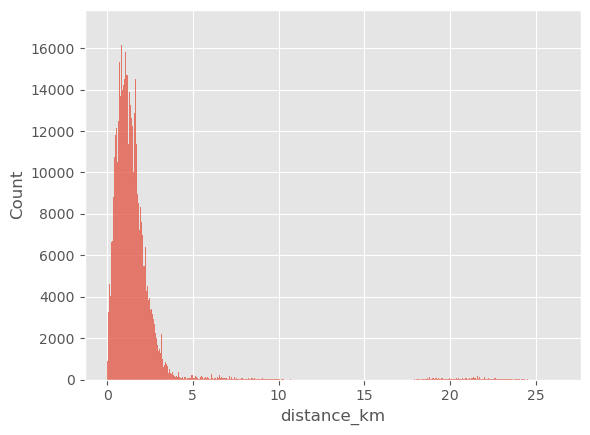

In [165]:
sns.histplot(clean_merge.distance_km)
plt.show(sns)

In [167]:
clean_merge.to_csv('clean_merge_v2.csv', sep=';', index=False)